In [1]:
import warnings
warnings.filterwarnings("ignore")

import env
import Liam_wrangle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import viz_kmeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [2]:
train = pd.read_csv('train_zillow.csv')

In [27]:
def cluster_longitude_latitude_houseage(train): 
    X = train[['longitude', 'latitude', 'house_age']]
    scaler = StandardScaler().fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

    #define the thing
    kmeans = KMeans(n_clusters=5, random_state = 123)

    # fit the thing
    kmeans.fit(X_scaled)

    # Use (predict using) the thing 
    kmeans.predict(X_scaled)
    train['longitude_latitude_houseage_cluster'] = kmeans.predict(X_scaled)
    X_scaled['longitude_latitude_houseage_cluster'] = kmeans.predict(X_scaled)

    # Cluster Centers aka (centroids)
    kmeans.cluster_centers_

    # Make a dataframe 
    centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

    # Plot the cluster
    # lets visualize the clusters along with the centers on (scaled data).
    plt.figure(figsize=(20, 20))

    # scatter plot of data with hue for cluster
    sns.scatterplot(x = 'longitude', y= 'latitude', data = X_scaled, hue = X_scaled.longitude_latitude_houseage_cluster, palette='viridis_r')
    centroids_scaled.plot.scatter(x = 'longitude', y= 'latitude', ax = plt.gca(), color = 'k', alpha = 0.3, s = 500, marker = 'o',)
    plt.legend();

    # Plot the clusers in relplot
    plt.figure(figsize=(14, 9))
    sns.relplot(x = 'longitude', y= 'latitude', data = X_scaled, col = X_scaled.longitude_latitude_houseage_cluster, col_wrap = 2, hue = train.level_of_log_error)
    plt.show();

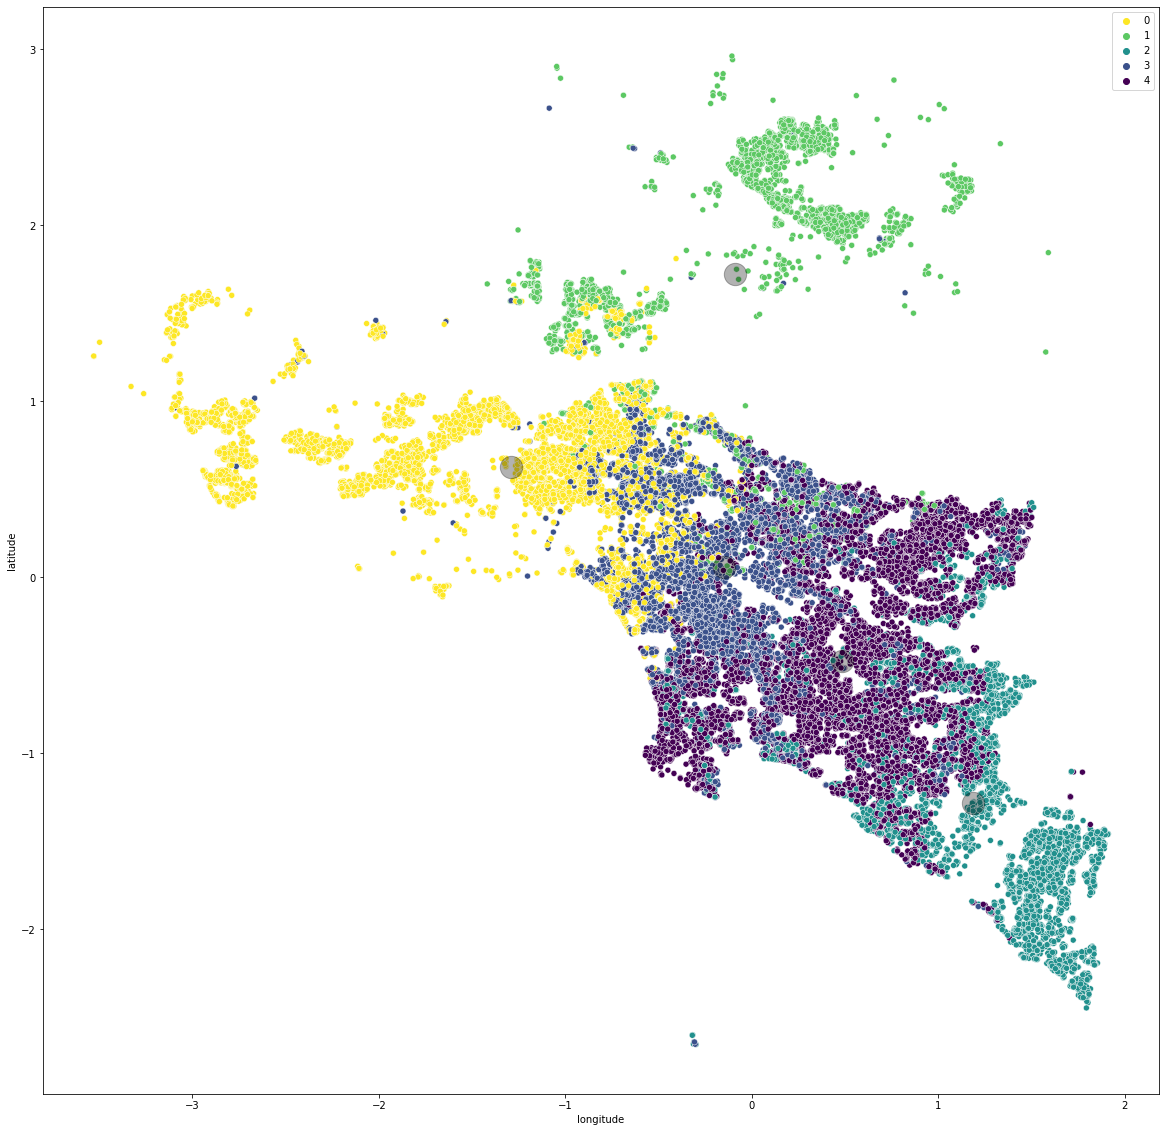

<Figure size 1008x648 with 0 Axes>

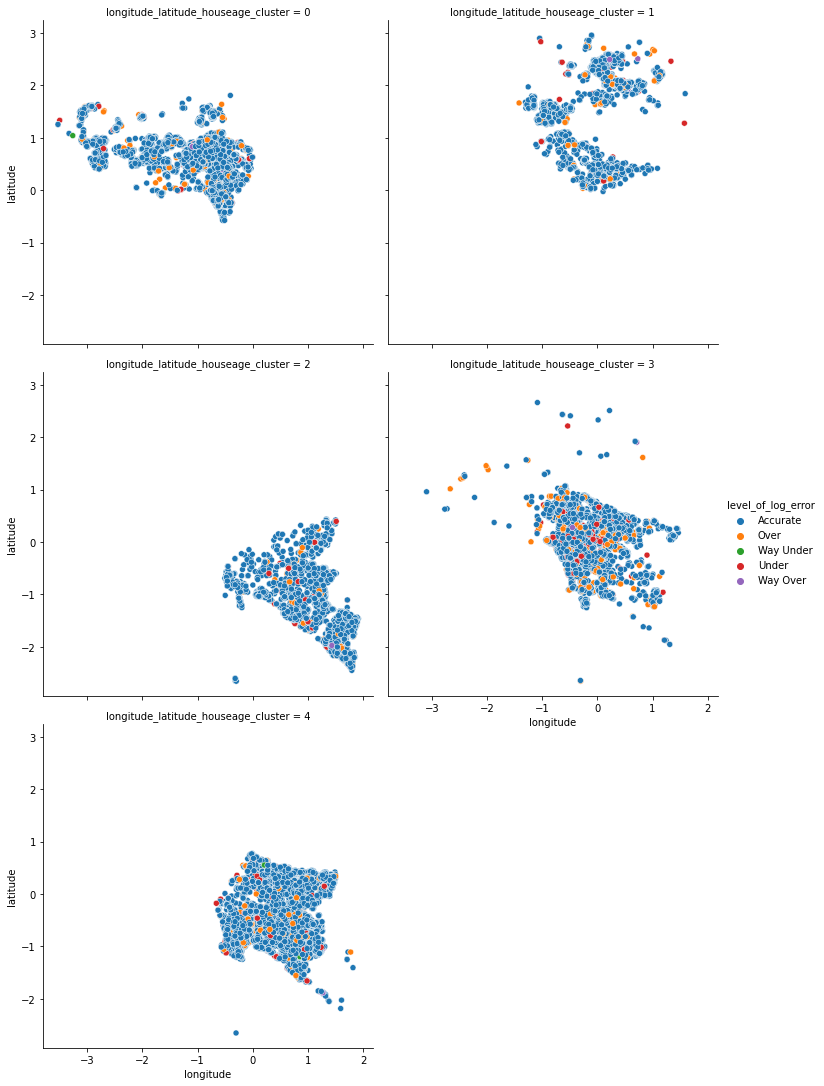

In [28]:
X_scaled = cluster_longitude_latitude_houseage(train)

# Findings
- cluster 0 = Ventura County
- cluster 1 = North LA
- cluster 2 = Orange County
- cluster 3 = North downtown LA
- cluster 4 = South LA



<AxesSubplot:xlabel='longitude', ylabel='latitude'>

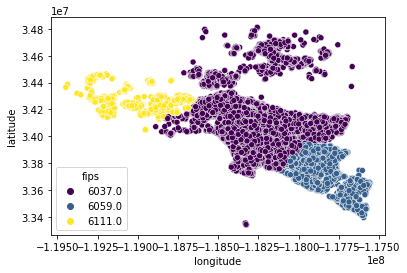

In [36]:
sns.scatterplot(x = train.longitude, y = train.latitude, hue = train.fips, palette='viridis')

In [29]:
def get_dum_and_plot2(train):   
    dummy_df =  pd.get_dummies(train['longitude_latitude_houseage_cluster'])
    dummy_df.columns = ['zero', 'one', 'two', 'three', 'four']
    df = pd.concat([train, dummy_df], axis=1)
    
    # Plot the clusters
    plt.figure(figsize=(20, 40))
    
    plt.subplot(5,1,1)
    plt.title("Percents of Each Log Error Level for Ventura", size=20, color='black')
    sns.barplot(y=df.zero, x='level_of_log_error', data=df,
                  palette='viridis')

    plt.subplot(5,1,2)
    plt.title("Percents of Each Log Error Level for Orange County", size=20, color='black')
    sns.barplot(y=df.one, x='level_of_log_error', data=df,
                   palette='viridis')

    plt.subplot(5,1,3)
    plt.title("Percents of Each Log Error Level for North downtown LA", size=20, color='black')
    sns.barplot(y=df.two, x='level_of_log_error', data=df,
                   palette='viridis')

    plt.subplot(5,1,4)
    plt.title("Percents of Each Log Error Level for East downtown LA", size=20, color='black')
    sns.barplot(y=df.three, x='level_of_log_error', data=df,
                   palette='viridis')
    
    plt.subplot(5,1,5)
    plt.title("Percents of Each Log Error Level for North LA", size=20, color='black')
    sns.barplot(y=df.four, x='level_of_log_error', data=df,
                   palette='viridis')

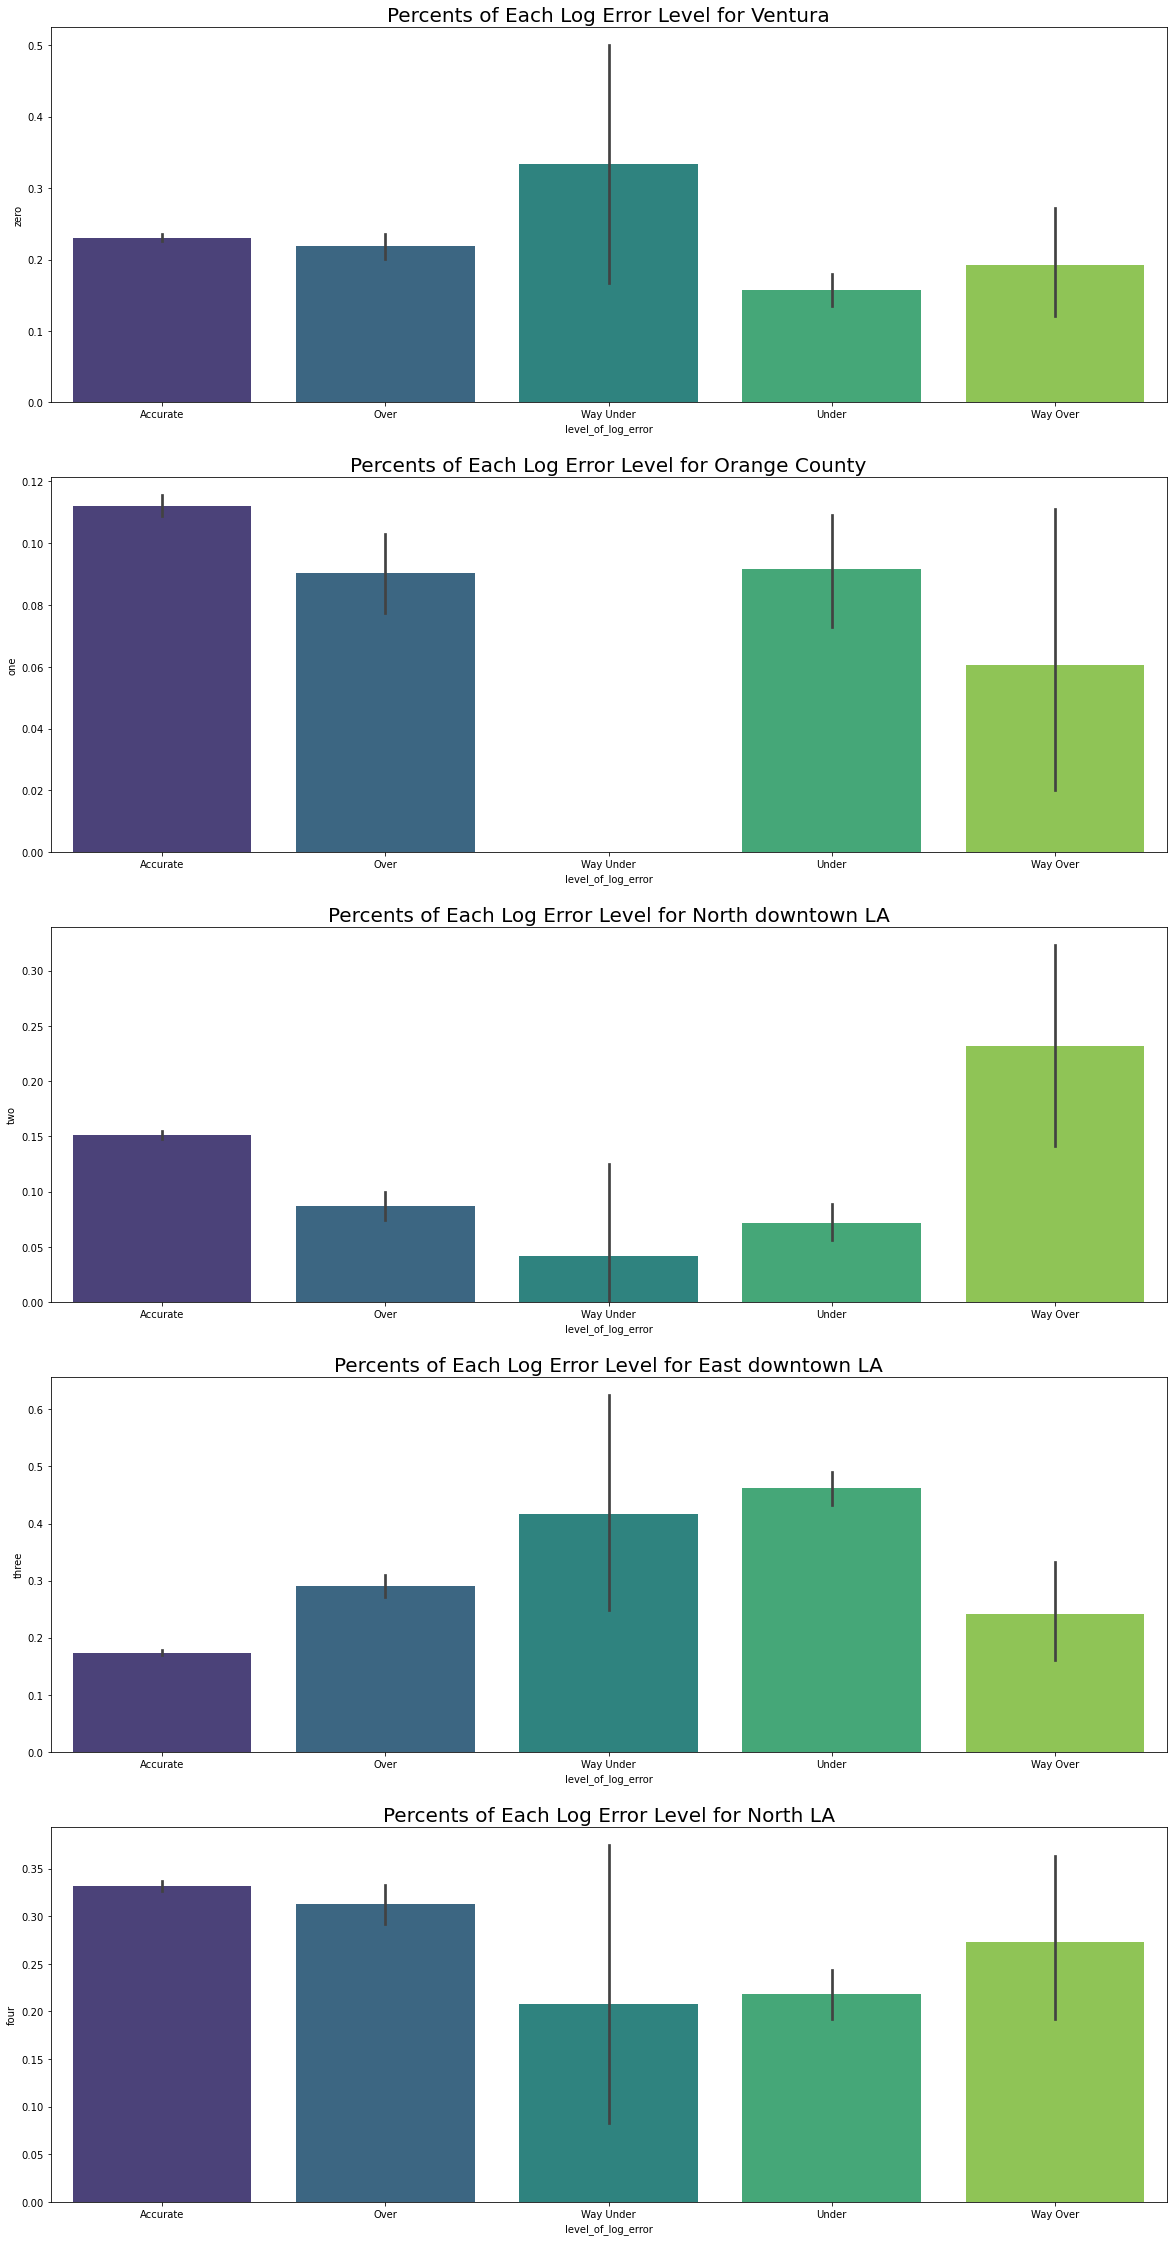

In [30]:
df = get_dum_and_plot2(train)

# Findings

- homes in venturea have higher logerrors than other types of log error.
- the majority of logerror comes from homes located in the cluster of East downtown LA. 


In [11]:
longitude_latitude_houseage_cluster_mean = (df.zero.mean() + df.one.mean() + df.two.mean() + df.three.mean() + df.four.mean())

In [12]:
clusters_population_mean = longitude_latitude_houseage_cluster_mean/5

In [13]:
t0, p0 = stats.ttest_1samp(df.zero, clusters_population_mean)
t1, p1 = stats.ttest_1samp(df.one, clusters_population_mean)
t2, p2 = stats.ttest_1samp(df.two, clusters_population_mean)
t3, p3 = stats.ttest_1samp(df.three, clusters_population_mean)
t4, p4 = stats.ttest_1samp(df.four, clusters_population_mean)

In [14]:
stats = {
    'Cluster': [df.zero,df.one,df.two,df.three,df.four],
    't_statistic': [t0, t1, t2, t3, t4],
    'p_value': [p0, p1, p2, p3, p4]
}

T_test_results = pd.DataFrame(stats)
T_test_results

,Cluster,t_statistic,p_value
0,0 0 1 1 2 0 3 0 4 ...,-32.834862,9.408872e-233
1,0 0 1 0 2 1 3 0 4 ...,0.578211,5.631253e-01
2,0 0 1 0 2 0 3 0 4 ...,-52.825937,0.000000e+00
3,0 1 1 0 2 0 3 1 4 ...,49.222327,0.000000e+00
4,0 0 1 0 2 0 3 0 4 ...,10.850912,2.193319e-27


In [16]:
# Keep:
# Cluster 1 = Ventura
# Cluster 3 = North downtown LA

# Drop:
# Cluster 2 = Orange County
# Cluster 4 = East downtown LA
# Cluster 5 = North LA 

In [19]:
from scipy import stats
null_hypo = 'There is no signficant difference between the log error means of each individual cluster.'
alt_hypo = 'There is a signficant difference between the log error means of at least one of the 3 clusters.'
alpha = 0.05
F, p = stats.f_oneway(train[X_scaled.longitude_latitude_houseage_cluster == 0].logerror,
                      train[X_scaled.longitude_latitude_houseage_cluster == 1].logerror,
                      train[X_scaled.longitude_latitude_houseage_cluster == 2].logerror,
                      train[X_scaled.longitude_latitude_houseage_cluster == 3].logerror,
                      train[X_scaled.longitude_latitude_houseage_cluster == 4].logerror)

In [20]:
if p < alpha:
    print('We reject the null hypothesis:\n',null_hypo, '\n')
    print('We continue forward with our alternative hypothesis:\n', alt_hypo,'\n')
else:
    print('We fail to reject the null hypothesis\n:', null_hypo,'\n')
    print('We stop here\n')
print('Anova Test Results on house_age and quality and roomcount Cluster')
print('Our F-value:\n',F)
print('Our P-value:\n',p)

We reject the null hypothesis:
 There is no signficant difference between the log error means of each individual cluster. 

We continue forward with our alternative hypothesis:
 There is a signficant difference between the log error means of at least one of the 3 clusters. 

Anova Test Results on house_age and quality and roomcount Cluster
Our F-value:
 6.677641756482532
Our P-value:
 2.2849583664433043e-05
